In [1]:
import boto3
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
import numpy as np
import copy
# from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoModelForTokenClassification, AutoModel
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# from huggingface_hub import login
# from sentence_transformers import SentenceTransformer


# Configure pandas to display all columns and their full content without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Do not truncate column contents
pd.set_option('display.expand_frame_repr', False)  # Avoid wrapping to the next line

## load questions and sql queries in spider train

In [2]:
# Define your S3 bucket and file key
bucket_name = 'sagemaker-studio-423623869859-3no3d9ie4hx'

# Initialize the S3 client
s3_client = boto3.client('s3')

# Load the file from S3
obj = s3_client.get_object(Bucket=bucket_name, Key='df_question_entities_tables.csv')
df_question_entities_tables = pd.read_csv(obj['Body'])
columns_whose_values_are_lists = ['entities_for_tables', 'entities_for_columns', 'tables', 'entities']
for column in columns_whose_values_are_lists:
    df_question_entities_tables[column] = df_question_entities_tables[column].apply(ast.literal_eval)

obj = s3_client.get_object(Bucket=bucket_name, Key='df_schema_table.csv')
df_schema_table = pd.read_csv(obj['Body'])

obj = s3_client.get_object(Bucket=bucket_name, Key='embeddings.json')
embedded_dict = json.load(obj['Body'])
for key in embedded_dict:
    embedded_dict[key] = np.array(embedded_dict[key])

In [3]:
ct = 0
ct_max = 5
for key in embedded_dict:
    print(key)
    print(len(embedded_dict[key]))
    ct += 1
    if ct == ct_max:
        break

what is the first name and last name employee helps the customer with first name leonie?
768
number of bedrooms
768
what are the title and director of the films without any schedule?
768
uganda
768
art instructors
768


In [4]:
df_question_entities_tables.shape

(7000, 6)

In [5]:
df_question_entities_tables.sample(frac=1)[['entities_for_tables', 'tables']].head(10)

,entities_for_tables,tables
4500,[documents],[documents]
124,[zip code],[weather]
1310,"[attendances, performances]",[performance]
2572,[rooms],[Rooms]
6292,[cities],"[city, temperature, hosting_city]"
149,"[stations, bike]","[status, station]"
6247,[ship],[ship]
5551,[products],"[ref_colors, products]"
1980,[phones],[phone]
1959,[films],[film]


In [6]:
df_schema_table.shape

(749, 5)

In [7]:
df_schema_table.head(3)

,database,table,processed_database,processed_table,database_and_table
0,academic,author,academic,author,academic author
1,academic,conference,academic,conference,academic conference
2,academic,domain,academic,domain,academic domain


## get corpus for retrieval

In [8]:
all_tables = []
for ind, row in df_question_entities_tables.iterrows():
    all_tables += row['tables']
    
all_tables = list(set(all_tables))
all_tables = [[ele] for ele in all_tables]
df_all_tables = pd.DataFrame(all_tables, columns=['table'])
df_all_tables['processed_table'] = df_all_tables['table'].apply(lambda x: ' '.join(segment for segment in x.split('_') if not segment.isdigit())
)
df_all_tables['processed_table'] = df_all_tables['processed_table'].apply(lambda x : x.lower())
df_all_tables['embedding'] = df_all_tables['processed_table'].map(embedded_dict)
df_all_tables.isna().sum()

table              0
processed_table    0
embedding          0
dtype: int64

In [9]:
search_corpus = df_all_tables[['embedding', 'processed_table', 'table']]\
.drop_duplicates(subset=['table']).values.tolist()

In [10]:
def cosine_similarity(vec1, vec2):
    
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    
    # Calculate cosine similarity
    result = dot_product / (norm_a * norm_b)
    return result

def search_for_a_single_entity(entity, search_corpus, embedded_dict):
    
    entity = entity.lower()
    search_corpus_copy = copy.deepcopy(search_corpus)
    entity_embedding = embedded_dict[entity]
    for ind, ele in enumerate(search_corpus_copy):
        document_embedding = ele[0]
        search_corpus_copy[ind].append(cosine_similarity(entity_embedding, document_embedding))
    return search_corpus_copy

def merge_and_sort_multiple_search_corpus_copies(list_of_search_corpus_copies):
    
    if list_of_search_corpus_copies == []:
        return None
    
    result = []
    for ind, ele in enumerate(list_of_search_corpus_copies[0]):
        result.append([])
        for search_corpus_copy in list_of_search_corpus_copies:
            result[-1].append(search_corpus_copy[ind][-1])
            
    search_corpus_copy_merged_and_sorted = []
    #print(result)
    for ind, ele in enumerate(list_of_search_corpus_copies[0]):
        search_corpus_copy_merged_and_sorted.append(ele[:-1]+[max(result[ind])])
        
    search_corpus_copy_merged_and_sorted.sort(key=lambda x: x[-1], reverse=True)
        
    return search_corpus_copy_merged_and_sorted
        

def find_index_of_a_table_from_ranked_list(target_table, search_corpus_copy_merged_and_sorted):
    
    if not search_corpus_copy_merged_and_sorted:
        return None
    
    list_of_sorted_tables = [ele[2] for ele in search_corpus_copy_merged_and_sorted]
    try:
        index = list_of_sorted_tables.index(target_table)
    except:
        index = None
        
    return index

def generate_list_of_similarity_scores_and_truth_labels(ground_truth_tables, search_corpus_copy_merged_and_sorted):
    
    list_of_similarity_scores_and_truth_labels = []
    for ele in search_corpus_copy_merged_and_sorted:
        table = ele[-2]
        similarity_score = ele[-1]
        if table in ground_truth_tables:
            list_of_similarity_scores_and_truth_labels.append([similarity_score, 1])
        else:
            list_of_similarity_scores_and_truth_labels.append([similarity_score, 0])
    
    return list_of_similarity_scores_and_truth_labels

####################################################################################################


df_question_entities_tables['ground_truth_table_indices'] = None
df_question_entities_tables['scores_and_truth_labels'] = None

for ind, row in df_question_entities_tables.iterrows():
    
    if ind % 1000 == 999:
        print(ind)
        
    ground_truth_tables = row['tables']
    entities_for_tables = [row['question']]
    list_of_search_corpus_copies = []
    
    if entities_for_tables == []:
        print('no entities for tables')
    for entity in entities_for_tables:
        list_of_search_corpus_copies.append(search_for_a_single_entity(entity, search_corpus, embedded_dict))
        
    search_corpus_copy_merged_and_sorted = merge_and_sort_multiple_search_corpus_copies(list_of_search_corpus_copies)
    #print(type(ground_truth_tables))
    
    ground_truth_table_indices = []
    #print(ground_truth_tables)
    flag_found_indices_for_all_ground_truth_tables = True
    for ground_truth_table in ground_truth_tables:
        index = find_index_of_a_table_from_ranked_list(ground_truth_table, search_corpus_copy_merged_and_sorted)
        ground_truth_table_indices.append(index)
        # index would be none if no entities for tables from the original question
        if index is None:
            print('index is None')
            flag_found_indices_for_all_ground_truth_tables = False
            break  
    if flag_found_indices_for_all_ground_truth_tables:  
        df_question_entities_tables.loc[ind, 'ground_truth_table_indices'] = ground_truth_table_indices
        list_of_similarity_scores_and_truth_labels = \
        generate_list_of_similarity_scores_and_truth_labels(ground_truth_tables, search_corpus_copy_merged_and_sorted)
        df_question_entities_tables.loc[ind, 'scores_and_truth_labels'] = list_of_similarity_scores_and_truth_labels
    else:
        continue

999
1999
2999
3999
4999
5999
6999


In [11]:
corpus_size = len(search_corpus)
corpus_size

616

In [12]:
df_question_entities_tables.sample(frac=1)[['question', 'tables', 'ground_truth_table_indices']].head(10)

,question,tables,ground_truth_table_indices
6704,How long is the total lesson time taught by staff with first name as Janessa and last name as Sawayn?,"[Staff, Lessons]","[9, 14]"
1405,Which year had the greatest number of courses?,[SECTION],[379]
6474,Count the number of different scientists assigned to any project.,[assignedto],[107]
4222,"Show the location code, the starting date and ending data in that location for all the documents.",[Document_locations],[0]
2207,"What are the drivers' first, last names and id who had more than 8 pit stops or participated in more than 5 race results?","[pitstops, drivers, results]","[13, 3, 12]"
500,How many students does each advisor have?,[Student],[38]
5837,How many workshops did each author submit to? Return the author name and the number of workshops.,"[submission, acceptance]","[8, 286]"
1630,"Show the name, open date, and organizer for all churches.",[Church],[1]
3211,Find the count and code of the job has most employees.,[employee],[10]
5574,"Find the number of the products that have their color described as ""red"" and have a characteristic named ""slow"".","[ref_colors, product_characteristics, products, CHARACTERISTICS]","[6, 0, 3, 48]"


In [13]:
df_question_entities_tables.shape

(7000, 8)

In [14]:
df_question_entities_tables['ground_truth_table_indices'].isna().sum()

0

In [15]:
df_question_entities_tables_not_null = df_question_entities_tables.loc[~df_question_entities_tables['ground_truth_table_indices'].isna()]

In [16]:
df_question_entities_tables_not_null.shape

(7000, 8)

In [17]:
# Create new columns safely without triggering a SettingWithCopyWarning
df_question_entities_tables_not_null = df_question_entities_tables_not_null.copy()

# Calculate "min_percentile" and "max_percentile"
df_question_entities_tables_not_null["min_percentile"] = df_question_entities_tables_not_null[
    "ground_truth_table_indices"
].apply(lambda x: min(x) / corpus_size)

df_question_entities_tables_not_null["max_percentile"] = df_question_entities_tables_not_null[
    "ground_truth_table_indices"
].apply(lambda x: max(x) / corpus_size)

## look at one single example

In [18]:
question = 'Find the name, class and rank of all captains.'
aaa = search_for_a_single_entity(question, search_corpus, embedded_dict)
aaa.sort(key=lambda x: x[-1], reverse=True)
df_aaa = pd.DataFrame([ele[1:] for ele in aaa][:10], columns=['processed_table', 'table', 'similarity_score'])
df_aaa['question'] = question
df_aaa[['processed_table', 'question', 'table', 'similarity_score']]

,processed_table,question,table,similarity_score
0,captain,"Find the name, class and rank of all captains.",captain,0.558074
1,club rank,"Find the name, class and rank of all captains.",club_rank,0.400478
2,ship,"Find the name, class and rank of all captains.",ship,0.373092
3,player coach,"Find the name, class and rank of all captains.",player_coach,0.360570
4,pilot,"Find the name, class and rank of all captains.",pilot,0.333049
5,departments,"Find the name, class and rank of all captains.",departments,0.318764
6,coach,"Find the name, class and rank of all captains.",coach,0.316901
7,staff department assignments,"Find the name, class and rank of all captains.",staff_department_assignments,0.306952
8,staff department assignments,"Find the name, class and rank of all captains.",Staff_Department_Assignments,0.306952
9,department,"Find the name, class and rank of all captains.",DEPARTMENT,0.304324


## evaluation metrics for retrieval

In [19]:
df_question_entities_tables_not_null.columns

Index(['question', 'entities_for_tables', 'entities_for_columns', 'query',
       'tables', 'entities', 'ground_truth_table_indices',
       'scores_and_truth_labels', 'min_percentile', 'max_percentile'],
      dtype='object')

In [20]:
df_question_entities_tables_not_null.sample(frac=1, random_state=14)\
[['question', 'entities_for_tables', 'entities_for_columns',\
  'tables', 'ground_truth_table_indices', 'min_percentile', 'max_percentile']].head(10)

,question,entities_for_tables,entities_for_columns,tables,ground_truth_table_indices,min_percentile,max_percentile
4718,Return the staff ids and genders for any staff with the title Department Manager.,[staff],"[staff ids, genders, title, Department Manager]","[staff, staff_department_assignments]","[8, 0]",0.000000,0.012987
3622,"What is the id, genre, and name of the artist for every English song ordered by ascending rating?","[artist, song]","[id, genre, name, English, rating]",[song],[16],0.025974,0.025974
1068,Show the players and the years played.,[players],"[players, years played]",[player],[4],0.006494,0.006494
2199,List the forenames of all distinct drivers in alphabetical order?,[drivers],[forenames],[drivers],[1],0.001623,0.001623
6720,What buildings have faculty offices?,"[buildings, faculty offices]","[buildings, faculty offices]",[Faculty],[4],0.006494,0.006494
1470,Find the names of all instructors in the Art department who have taught some course and the course_id.,"[instructors, course]","[names, Art department, course_id]","[instructor, teaches]","[6, 36]",0.009740,0.058442
3185,"How many credits does course CIS-220 have, and what its description?",[course],"[credits, description, CIS-220]",[course],[40],0.064935,0.064935
3210,How many different professors are there for the different schools?,"[professors, schools]",[count],"[professor, department]","[5, 48]",0.008117,0.077922
6003,List ids for all student who are on scholarship.,[student],"[ids, scholarship]",[Sportsinfo],[70],0.113636,0.113636
4904,Find the name and population of district with population between 200000 and 2000000,[district],"[name, population]",[district],[0],0.000000,0.000000


In [21]:
corpus_size

616

In [22]:
def calculate_quantiles(df, quantile_steps=0.1):

    # Select numeric columns only
    numeric_columns = df.select_dtypes(include=[np.number])
    
    # Calculate quantiles
    quantiles = numeric_columns.quantile(
        q=np.arange(0, 1 + quantile_steps, quantile_steps), axis=0, numeric_only=True
    )
    quantiles.index = [f"{int(q * 100)}%" for q in quantiles.index]  # Format index as percentages
    quantiles = (quantiles * 100).round(3).astype(str) + "%"  # Convert values to percentages and append '%'
    return quantiles

# Calculate quantiles with 10% steps
quantiles_df = calculate_quantiles(df_question_entities_tables_not_null, quantile_steps=0.1)

# Display the quantiles DataFrame
print(quantiles_df)

     min_percentile max_percentile
0%             0.0%           0.0%
10%            0.0%           0.0%
20%            0.0%         0.162%
30%            0.0%         0.325%
40%          0.162%         0.487%
50%          0.162%         0.812%
60%          0.325%         1.299%
70%          0.649%          2.11%
80%          1.136%         3.896%
90%          2.273%        11.851%
100%        93.344%        93.994%


## AUC-ROC and AUC-PRC

In [23]:
all_scores_and_labels = []

for ind, row in df_question_entities_tables_not_null.iterrows():
    one_example_scores_and_labels = row['scores_and_truth_labels']
    all_scores_and_labels += one_example_scores_and_labels

In [24]:
all_scores_and_labels[:5]

[[0.47797647744686456, 0],
 [0.4388512513326294, 0],
 [0.4388512513326294, 0],
 [0.43520320550679276, 0],
 [0.43520320550679276, 0]]

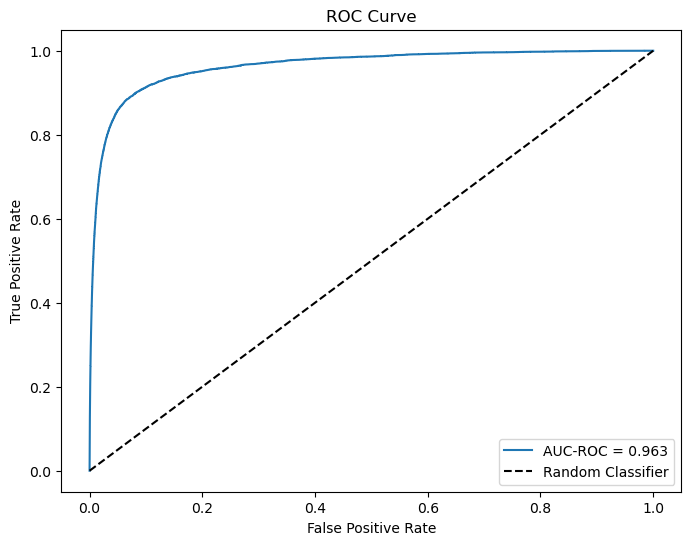

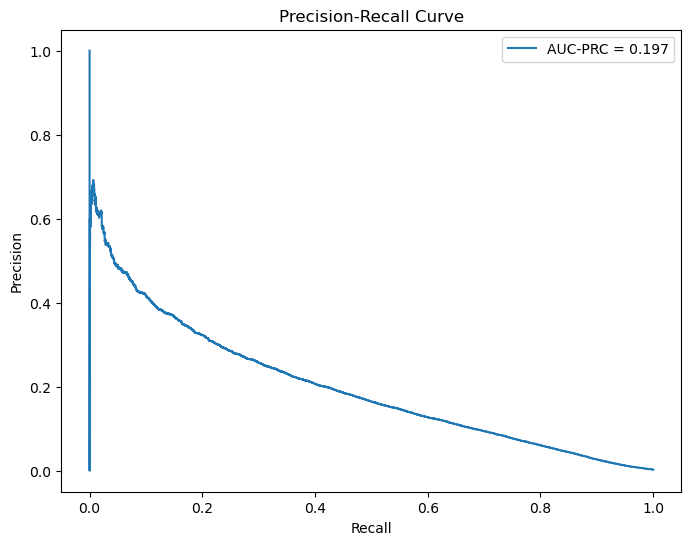

{'Balance Ratio': 0.002528061224489796,
 'AUC-ROC': 0.9632216419242238,
 'AUC-PRC': 0.19713283079041935,
 'AUC-PRC/balance_ratio': 78.0,
 'Precision at 90.0% recall': '2.7%'}

In [25]:
def evaluate_model(predictions):
    """
    Evaluate model predictions by calculating and plotting:
    1. Balance ratio
    2. ROC curve and AUC-ROC
    3. Precision-Recall curve and AUC-PRC
    4. Precision when recall > 0.95
    
    Args:
        predictions (list of lists): A list where each entry is [score, true_label].

    Returns:
        dict: Dictionary containing balance ratio, AUC-ROC, AUC-PRC, and precision when recall > 0.95.
    """
    # Separate scores and true labels
    y_scores = [item[0] for item in predictions]
    y_true = [item[1] for item in predictions]
    
    # Calculate balance ratio
    balance_ratio = sum(y_true) / len(y_true)
    
    # Calculate ROC curve and AUC-ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    # Calculate Precision-Recall curve and AUC-PRC
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    prc_auc = auc(recall, precision)
    
    # Reverse precision and recall for ascending recall order
    precision = precision[::-1]
    recall = recall[::-1]
    
    # Find precision when recall > 0.95
    threshold_recall = 0.9
    precision_at_threshold_recall = None
    for p, r in zip(precision, recall):
        if r > threshold_recall:
            precision_at_threshold_recall = p
            break
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"AUC-PRC = {prc_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    # Return results
    return {
        "Balance Ratio": balance_ratio,
        "AUC-ROC": roc_auc,
        "AUC-PRC": prc_auc,
        "AUC-PRC/balance_ratio": round(prc_auc / balance_ratio, 0),
        "Precision at {}% recall".format(threshold_recall*100): str(round(precision_at_threshold_recall*100,1))+'%'
    }

evaluate_model(all_scores_and_labels)

## save result as .csv and upload to S3

In [26]:
# Save the DataFrame to a local CSV file
file_name = 'df_question_entities_tables_not_null_v2.csv'
df_question_entities_tables_not_null.to_csv(file_name, index=False, header=True)

# Upload the CSV file to the specified S3 bucket
s3_client.upload_file(file_name, bucket_name, file_name)

print(f"File {file_name} successfully uploaded to s3://{bucket_name}/{file_name}")

File df_question_entities_tables_not_null_v2.csv successfully uploaded to s3://sagemaker-studio-423623869859-3no3d9ie4hx/df_question_entities_tables_not_null_v2.csv
